<a href="https://colab.research.google.com/github/rishranyal/Supersnonic-Turbojet-Engine-Cycle-Design-/blob/main/Supersonic_turbojet_project_cff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization Known Parameters**

In [ ]:
gamma = 1.4  # Specific heat ratio for air
R = 287.05   # Specific gas constant for air (J/kg·K)
M1 = 3.2    # Free-stream Mach number
altitude = 24384  # in meters  (80,000 ft)  # Example altitude in meters

# **Free stream conditions**

In [ ]:
import math
if altitude <= 11000:
        T1 = 288.15 - 0.0065 * altitude
        P1 = 101325 * (T1 / 288.15) ** (5.2561)
else:  # Stratosphere (constant temperature)
        T1 = 216.65
        P1 = 22632.1 * math.exp(-9.80665 * (altitude - 11000) / (R * T1))

# Calculate free-stream conditions
T01 = T1 * (1 + ((gamma - 1) / 2) * M1**2)
P01 = P1 * (1 + ((gamma - 1) / 2) * M1**2)**(gamma / (gamma - 1))
c1 = math.sqrt(gamma * R * T1)  # Speed of sound (m/s)
V1 = M1 * c1  # Free-stream velocity (m/s)

print(f"Free-stream static temperature (T1): {T1:.2f} K")
print(f"Free-stream stagnation temperature (T01): {T01:.2f} K")
print(f"Free-stream static pressure (P1): {P1/1000:.2f} kPa")
print(f"Free-stream stagnation pressure (P01): {P01/1000:.2f} kPa")
print(f"Free-stream speed of sound (c1): {c1:.2f} m/s")
print(f"Free-stream velocity (V1): {V1:.2f} m/s")

Free-stream static temperature (T1): 216.65 K
Free-stream stagnation temperature (T01): 660.35 K
Free-stream static pressure (P1): 2.74 kPa
Free-stream stagnation pressure (P01): 135.58 kPa
Free-stream speed of sound (c1): 295.07 m/s
Free-stream velocity (V1): 944.22 m/s


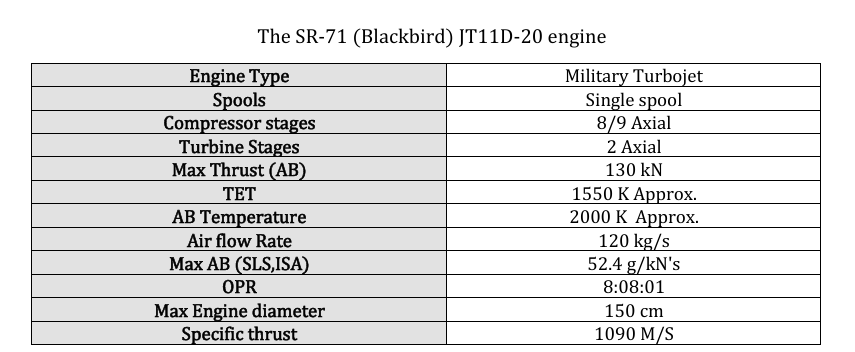

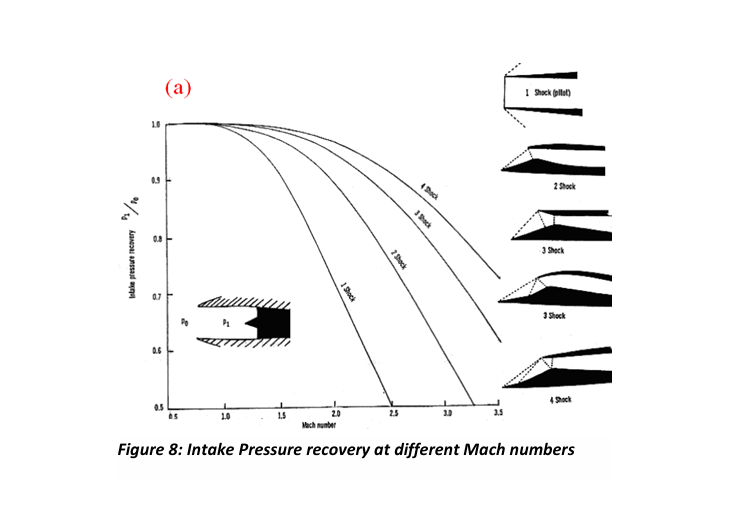
  Number of shocks anlalysis

  number of shcks fro the grpah will be counted and the pressure recovery factor is known

**Number of Shocks required at compresser inlet**

In [ ]:
import math
# Constants
gamma = 1.4
delta_1 = 9.3844  # Initial ramp angle in degrees
delta_inc = 2.5  # Ramp angle increment in degrees
if(M1>=1.25):
  total_shocks=4
else:
  total_shocks=3
n = total_shocks-1  # Number of ramps
delta = [] # Initialize an array for ramp angles
for k in range(n):
    delta.append(delta_1 + k * delta_inc)
print("Ramp Angles (degrees):", delta)
for i in range(len(delta)):
    print(f"Ramp Angle {i + 1}: {delta[i]} degrees")


Ramp Angles (degrees): [9.3844, 11.8844, 14.3844]
Ramp Angle 1: 9.3844 degrees
Ramp Angle 2: 11.8844 degrees
Ramp Angle 3: 14.3844 degrees


# **OBLIQUE SHOCKS**

In [ ]:
import numpy as np
from scipy.optimize import fsolve
def oblique_shock_calculation(M1, theta, gamma):
    theta_rad = np.radians(theta)
    def beta_eq(beta):
        return np.tan(theta_rad) - 2 * (1 / np.tan(beta)) * (
            (M1**2 * np.sin(beta)**2 - 1) /
            (M1**2 * (gamma + np.cos(2 * beta)) + 2)
        )
    beta_initial = np.radians(theta + 5)
    try:
        beta_solution = fsolve(beta_eq, beta_initial, xtol=1e-6)
        beta = beta_solution[0]  # Shock angle in radians
        if not (0 < beta < np.pi / 2):  # Check for valid shock angle
            raise ValueError("Shock angle out of bounds.")
    except (RuntimeError, ValueError):
        return None, None, None  # Return None if solution fails

    # Calculate downstream Mach number
    M1n = M1 * np.sin(beta)  # Normal component of upstream Mach number
    M2n = np.sqrt(((gamma - 1) * M1n**2 + 2) / (2 * gamma * M1n**2 - (gamma - 1)))
    M2 = M2n / np.sin(beta - theta_rad)

    # Calculate pressure recovery ratio (Eqn. 4 from image)
    PR = (
        ((gamma + 1) * M1n**2 / ((gamma - 1) * M1n**2 + 2)) ** (gamma / (gamma - 1))
        * ((gamma + 1) / (2 * gamma * M1n**2 - (gamma - 1))) ** (1 / (gamma - 1))
    )

    # Return shock angle, downstream Mach number, and pressure recovery ratio
    return np.degrees(beta), M2, PR


numshocks = len(delta)
intermediate_mach_numbers = [M1]
shock_angles = []
pressure_recovery_ratios = []
M_current=M1
for i, theta in enumerate(delta):
      beta, M_next, PR = oblique_shock_calculation(M_current, theta, gamma)
      if beta is None or M_next is None or PR is None:
            print(beta, M_next, PR)
            print(f"Warning: Convergence failed for ramp angle {theta} degrees at shock {i + 1}.")
            break
      shock_angles.append(beta)
      pressure_recovery_ratios.append(PR)
      intermediate_mach_numbers.append(M_next)
      M_current = M_next  # Update for the next shock

print("Final Mach Number after oblique shocks", intermediate_mach_numbers[-1] if shock_angles else None)
print("Intermediate Mach Numbers:",  intermediate_mach_numbers)
print("Shock Angles (degrees):", shock_angles)
print("Pressure Recovery Ratios:", pressure_recovery_ratios)

tprr = 1.0

# Loop through all shocks to compute the cumulative product
for i in range(len(pressure_recovery_ratios)):
    tprr *= pressure_recovery_ratios[i]
# Output the final total pressure recovery ratio
print("Total Pressure Recovery Ratio after oblique shocks (TPRR):", tprr)


Final Mach Number after oblique shocks 1.6255543377270771
Intermediate Mach Numbers: [3.2, 2.6995193938546977, 2.171736554555608, 1.6255543377270771]
Shock Angles (degrees): [25.499967022028276, 31.619928345659527, 41.03380314554973]
Pressure Recovery Ratios: [0.9635883703602292, 0.9542919908980083, 0.9515336394886574]
Total Pressure Recovery Ratio after oblique shocks (TPRR): 0.8749776811482114


# **NORMAL SHOCK**

In [ ]:
import numpy as np
PR_diffuser=0.98
M_last = intermediate_mach_numbers[-1]  # Replace with the Mach number after the oblique shocks
M2_normal = np.sqrt(((gamma - 1) * M_last**2 + 2) / (2 * gamma * M_last**2 - (gamma - 1)))
PR_normal = (
        ((gamma + 1) * M_last**2 / ((gamma - 1) * M_last**2 + 2)) ** (gamma / (gamma - 1))
        * ((gamma + 1) / (2 * gamma * M_last**2 - (gamma - 1))) ** (1 / (gamma - 1))
    )
tprr*=PR_normal*PR_diffuser
print("Downstream Mach Number after Normal Shock:", M2_normal)
print("Pressure Recovery Ratio (PR_normal):",PR_normal)
print("Final Pressure Recovery Ratio (TPRR):", tprr)

Downstream Mach Number after Normal Shock: 0.6608973274974246
Pressure Recovery Ratio (PR_normal): 0.885523636837709
Final Pressure Recovery Ratio (TPRR): 0.7593171499949457


**Pressure After Shocks (Compresser Inlet)**

In [ ]:
P02=tprr*P01  # Stagnation Pressure at compresser inlet
P2=P02/(1 + ((gamma - 1) / 2) * M2_normal**2)**(gamma / (gamma - 1))
print("Stagnation Pressure at compressor inlet, P02=",P02/1000,"kPa")
print("Static Pressure at compressor inlet, P2=",P2/1000,"kPa")

Stagnation Pressure at compressor inlet, P02= 102.94644878383 kPa
Static Pressure at compressor inlet, P2= 76.79072202434786 kPa


**Temp After Shock (Compresser Inlet)**

In [ ]:
#inlet statsic temperature is T1
import numpy as np
Mn_list = intermediate_mach_numbers  # List of normal Mach numbers after each shock
temperatures=[T1]
for i in range(1,len(Mn_list)):
        # Update static temperature for the next shock
        T2 = T01 / (1 + ((gamma - 1) / 2) * Mn_list[i]**2)
        temperatures.append(T2)


for i, temp in enumerate(temperatures):
        if i == 0:
            print(f"Initial Static Temperature T1: {temp:.2f} K")
        else:
            print(f"Static Temperature after Shock {i}: {temp:.2f} K")

T2 = T01/(1 + ((gamma - 1) / 2) * M2_normal**2)
print(f"Static Temperature after normal shock : {T2:.2f} K")
T02=T01
print(f"Stagnation Tempearture after normal shock : {T02:.2f} K") #it remain constant over all shocks

Initial Static Temperature T1: 216.65 K
Static Temperature after Shock 1: 268.71 K
Static Temperature after Shock 2: 339.81 K
Static Temperature after Shock 3: 432.03 K
Static Temperature after normal shock : 607.30 K
Stagnation Tempearture after normal shock : 660.35 K


In [ ]:
soundspeed_after_normal_shock= math.sqrt(gamma*R*T2)
print("c just after normal shock = ",soundspeed_after_normal_shock)
velocity=M2_normal*soundspeed_after_normal_shock
print("velocity just after normal shock = " ,velocity)

c just after normal shock =  494.01886442885706
velocity just after normal shock =  326.49574723434415


# **COMPRESSOR**

In [ ]:
eta_c=0.91
pi_c=9
T03 = T02 * (1 + (1 / eta_c) * (pi_c**((gamma - 1) / gamma) - 1))

P03 = P02 * pi_c
print(f"Compresser outlet Stagnation Temperature T03: {T03:.2f} K")
print("Stagnation Pressure at compressor outlet, P03=",P03/1000,"kPa")


Compresser outlet Stagnation Temperature T03: 1294.17 K
Stagnation Pressure at compressor outlet, P03= 926.51803905447 kPa


In [ ]:
T04=1550 #turbine inlet stagnation temperature
TET=T04
eta_b=0.988
delta_Pcc=0.02 # 2 % loss
Qr = 42000000  # Heating value of fuel (J/kg)
cp= 1005  # Specific heat of air (J/kg·K)
cp_h = 2300  # Specific heat of fuel  (J/kg·K)


# **Combustion chamber**

In [ ]:
 # Compute the fuel-air ratio (f)
numerator = cp_h*T04 -cp*T03 #cp_h fuel specefic heat and cp air specific heat
denominator = eta_b * Qr - cp_h * T04
f = numerator / denominator
m_air=120
m_fuel=m_air*f
P04 = P03 * (1 - delta_Pcc)
print(f"Stagnation Pressure at outlet of combustion chamber = {P04/1000:.2f} Kpa")
print("fuel - air ratio = ",f)
print("mass flow rate of fuel = ",m_fuel)



Stagnation Pressure at outlet of combustion chamber = 907.99 Kpa
fuel - air ratio =  0.05969676283877286
mass flow rate of fuel =  7.1636115406527425


In [ ]:
numerator = cp + f * cp_h
denominator = 1 + f
cp_m = numerator / denominator
print("Specific Heat Capacity of the Mixture (c_p_mixture):", round(cp_m, 2), "J/kg·K")


Specific Heat Capacity of the Mixture (c_p_mixture): 1077.95 J/kg·K


# **Turbine**

In [ ]:
eta_t=0.87
lambd=0.8
eta_m=0.99
gamma_h=1.364
R_air = 287
R_mixture = R_air/(1+f)
print("Mixture R = ",R_mixture)

Mixture R =  270.83219470367067


In [ ]:
T05 = T04* (1-(((cp/cp_m)*T02)/(lambd*eta_m*(1+f)*T04))*((T03/T02)-1))
print(f"Stagnation Temperature at Turbine Outlet {T05:.2f} K")

P05=P04*((1-(1/eta_t)*(1-(T05/T04))))** (gamma_h / (gamma_h - 1))
print(f"Stagnation Pressure at Turbine Outlet {P05/1000:.2f} Kpa")

W_t = eta_m * lambd * eta_t * cp_h * (T04-T05)
print("Turbine Work = ",W_t/1000,"kJ")



Stagnation Temperature at Turbine Outlet 845.91 K
Stagnation Pressure at Turbine Outlet 57.07 Kpa
Turbine Work =  1115.833341713164 kJ


In [ ]:

# Enthalpy at turbine inlet and outlet
h04 = cp_m * T04  # Enthalpy at turbine inlet (J/kg)
h05 = cp_m * T05  # Enthalpy at turbine outlet (J/kg)

# Enthalpy change (turbine work)
delta_h = h04 - h05

# Print results
print(f"Enthalpy at Turbine Inlet (h04): {h04 / 1000:.2f} kJ/kg")
print(f"Enthalpy at Turbine Outlet (h05): {h05 / 1000:.2f} kJ/kg")
print(f"Change in Enthalpy (Delta h): {delta_h / 1000:.2f} kJ/kg")


Enthalpy at Turbine Inlet (h04): 1670.83 kJ/kg
Enthalpy at Turbine Outlet (h05): 911.85 kJ/kg
Change in Enthalpy (Delta h): 758.97 kJ/kg


**Throat**

In [ ]:
P_throat = P05/(1/(1+(gamma_h-1)/2*1**2)**(gamma_h/(gamma_h-1)))
print(f"Throat Pressure {P_throat/1000:.2f} Kpa")
T_throat = T05/(1/(1+(gamma_h-1)/2*1**2))
print(f"Throat Temperature {T_throat:.2f} K")
density_throat = P_throat / (R_mixture * T_throat)
print(f"Throat Density {density_throat:.2f} kg/m^3")
Area_throat = m_fuel / density_throat
print(f"Throat Area {Area_throat:.2f} m^2")
pressure_ratio = P05 / P1
M_exit = math.sqrt((2 / (gamma_h - 1)) * ((pressure_ratio**((gamma_h - 1) / gamma_h)) - 1))
print(f"Exit Mach {M_exit:.2f}")
T_exit = T05 / (1 + ((gamma_h - 1) / 2) * M_exit**2)
print(f"Exit Temperature {T_exit:.2f} K")
c_exit = math.sqrt(gamma_h * R * T_exit)
print(f"Exit Sound Speed {c_exit:.2f} m/s")
v_exit = M_exit * c_exit
print(f"Exit Velocity {v_exit:.2f} m/s")
m_total = m_air+m_fuel
Thrust = m_total*v_exit
print(f"Net Thrust {Thrust/1000:.2f} KN")
P_exit = P05 / (1 + ((gamma_h - 1) / 2) * M_exit**2)**(gamma_h / (gamma_h - 1))
print(f"Exit Pressure {P_exit/1000:.2f} Kpa")
density_exit = P_exit / (R_mixture * T_exit)
print(f"Exit Density {density_exit:.2f} kg/m^3")
Area_exit = m_total / density_exit
print(f"Exit Area {Area_exit:.2f} m^2")


Throat Pressure 106.78 Kpa
Throat Temperature 999.87 K
Throat Density 0.39 kg/m^3
Throat Area 18.17 m^2
Exit Mach 2.62
Exit Temperature 376.30 K
Exit Sound Speed 383.84 m/s
Exit Velocity 1005.12 m/s
Net Thrust 127.82 KN
Exit Pressure 2.74 Kpa
Exit Density 0.03 kg/m^3
Exit Area 4725.66 m^2


In [ ]:

    # Calculate thermal efficiency
thermal_efficiency = 1 - (T02/T04)

    # Calculate propulsive efficiency
propulsive_efficiency = 2 / (1 + (v_exit / V1))

    # Calculate overall efficiency
overall_efficiency = thermal_efficiency * propulsive_efficiency


# Calculate efficiencies
eta_thermal = thermal_efficiency
eta_propulsive = propulsive_efficiency
eta_overall = overall_efficiency
# Print results
print(f"Thermal Efficiency: {eta_thermal:.2f} or {eta_thermal * 100:.2f}%")
print(f"Propulsive Efficiency: {eta_propulsive:.2f} or {eta_propulsive * 100:.2f}%")
print(f"Overall Efficiency: {eta_overall:.2f} or {eta_overall * 100:.2f}%")


Thermal Efficiency: 0.57 or 57.40%
Propulsive Efficiency: 0.97 or 96.88%
Overall Efficiency: 0.56 or 55.60%


# **END**